# Approximate Rates

pynucastro can use rate approximations for $A(\alpha,\gamma)B$ and $A(\alpha,p)X(p,\gamma)B$,
combining them into a single effective rate by assuming that the protons and nucleus $X$ are in equilibrium.

In [1]:
import pynucastro as pyna
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Let's create a simple network that has both an $(\alpha, \gamma)$ and
$(\alpha, p)(p, \gamma)$ sequence.

In [2]:
reaclib = pyna.ReacLibLibrary()
mylib = reaclib.linking_nuclei(["mg24", "al27", "si28",
                                        "p31", "s32", "he4", "p"])
pynet = pyna.PythonNetwork(libraries=[mylib])
pynet.write_network("full_net.py")

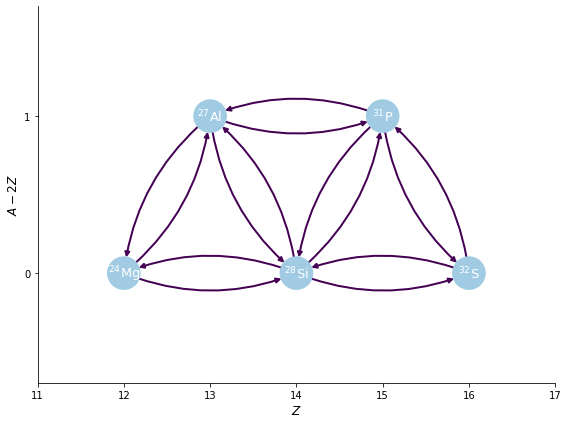

In [3]:
pynet.plot(rotated=True, curved_edges=True, outfile="approx_diagram_full.pdf")

In [4]:
import full_net

## Integrating the full network

Now let's integrate this.  We'll start with half ${}^{24}\mathrm{Mg}$ and half $\alpha$ by mass.

In [5]:
rho = 1.e7
T = 3e9

X0 = np.zeros(full_net.nnuc)
X0[full_net.jhe4] = 0.5
X0[full_net.jmg24] = 0.5

Y0 = X0 / full_net.A

In [6]:
tmax = 1.e-3
sol = solve_ivp(full_net.rhs, [0, tmax], Y0, method="BDF",
                dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-10)

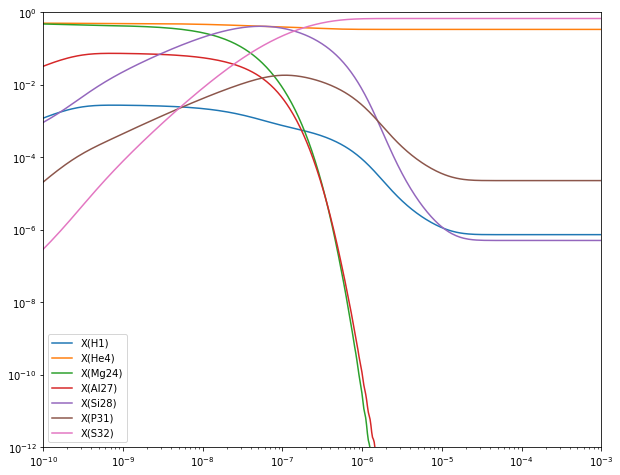

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(full_net.nnuc):
    ax.loglog(sol.t, sol.y[i,:] * full_net.A[i], label=f"X({full_net.names[i].capitalize()})")

ax.legend()

ax.set_xlim(1.e-10, 1.e-3)
ax.set_ylim(1.e-12, 1)
fig.set_size_inches((10, 8))

## Approximate Version

Now we will approximate the rates, combining $(\alpha, \gamma)$ and
$(\alpha, p)(p, \gamma)$ into a single effective rate.

The routine `make_ap_pg_approx()` will find all of the rates that make up that sequence and create a
single `ApproximateRate` that captures the effective rate.  The original rates will still be stored in the `ApproximateRate` object and will be evaluated to compute the needed approximation when the effective rate is evaluated.

In [8]:
pynet.make_ap_pg_approx()

using approximate rate Mg24 + He4 ⟶ Si28 + 𝛾
using approximate rate Si28 ⟶ Mg24 + He4
using approximate rate Si28 + He4 ⟶ S32 + 𝛾
using approximate rate S32 ⟶ Si28 + He4
removing rate Mg24 + He4 ⟶ Si28 + 𝛾
removing rate Mg24 + He4 ⟶ p + Al27
removing rate Al27 + p ⟶ Si28 + 𝛾
removing rate Si28 ⟶ He4 + Mg24
removing rate Si28 ⟶ p + Al27
removing rate Al27 + p ⟶ He4 + Mg24
removing rate Si28 + He4 ⟶ S32 + 𝛾
removing rate Si28 + He4 ⟶ p + P31
removing rate P31 + p ⟶ S32 + 𝛾
removing rate S32 ⟶ He4 + Si28
removing rate S32 ⟶ p + P31
removing rate P31 + p ⟶ He4 + Si28


In [9]:
pynet

P31 ⟶ He4 + Al27
Al27 + He4 ⟶ P31 + 𝛾
Mg24 + He4 ⟶ Si28 + 𝛾
Si28 ⟶ Mg24 + He4
Si28 + He4 ⟶ S32 + 𝛾
S32 ⟶ Si28 + He4

Since we no longer care about the ${}^{27}\mathrm{Al}$ and ${}^{31}\mathrm{P}$, we can remove them from the network.  The `ApproximateRate` object still knows that these are the intermediate nucleus, but now they
won't explicitly appear as one of the nuclei in the network.

In [10]:
pynet.remove_nuclei(["al27", "p31"])

looking to remove P31 ⟶ He4 + Al27
looking to remove Al27 + He4 ⟶ P31 + 𝛾
looking to remove P31 ⟶ He4 + Al27
looking to remove Al27 + He4 ⟶ P31 + 𝛾


Note that since no reactions consume protons after that removal, the protons are all removed from the network, reducing its size from 7 nuclei to 4

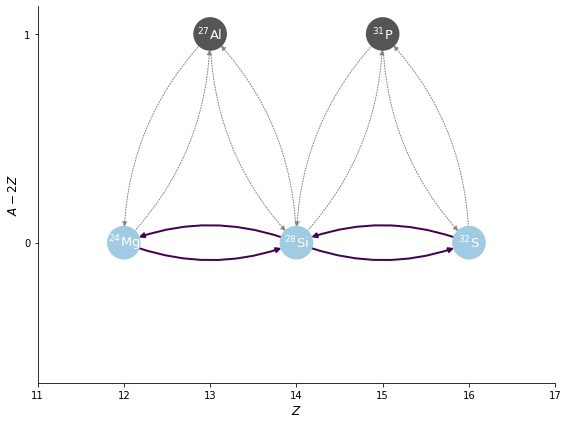

In [11]:
pynet.plot(rotated=True, curved_edges=True, outfile="approx_diagram.pdf")

As we see above, the nuclei ${}^{27}\mathrm{Al}$ and ${}^{31}\mathrm{P}$ no longer appear in the network, but  the links to them are still understood to the network.  This reduces the size of the network, while still preserving those flows.

In [12]:
pynet.write_network("approx_net.py")

In [13]:
import approx_net

## Integrating the approximate network

Let's integrate this approximate net and compare to above

In [14]:
rho = 1.e7
T = 3.e9

X0 = np.zeros(approx_net.nnuc)
X0[approx_net.jhe4] = 0.5
X0[approx_net.jmg24] = 0.5

Y0 = X0 / approx_net.A

In [15]:
tmax = 1.e-3
approx_sol = solve_ivp(approx_net.rhs, [0, tmax], Y0, method="BDF",
                       dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-10)

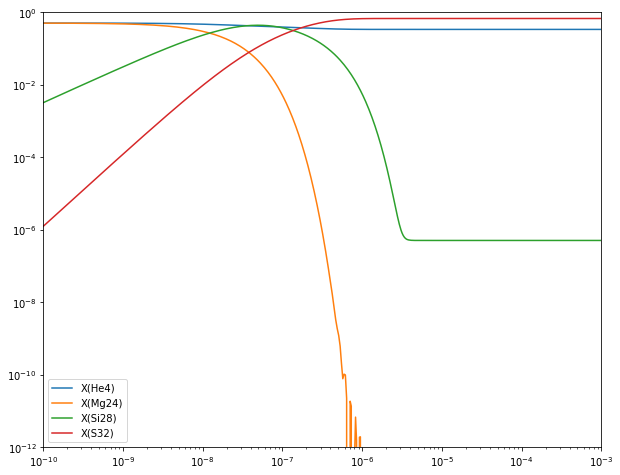

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(approx_net.nnuc):
    ax.loglog(approx_sol.t, approx_sol.y[i,:] * approx_net.A[i], label=f"X({approx_net.names[i].capitalize()})")

ax.legend()
ax.set_xlim(1.e-10, 1.e-3)
ax.set_ylim(1.e-12, 1)

fig.set_size_inches((10, 8))

## Comparison

Let's plot both on the same axes to see the comparison.

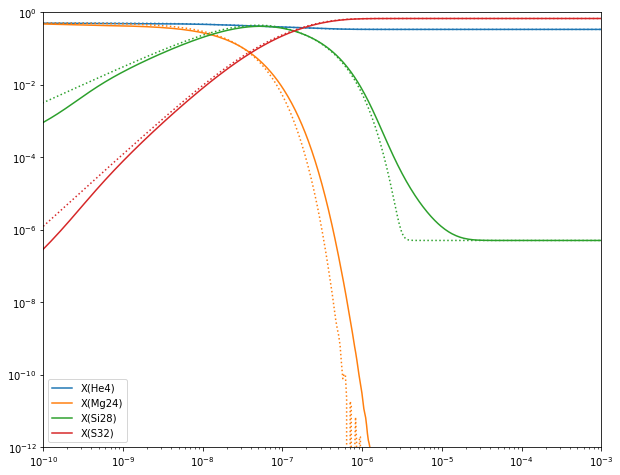

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(approx_net.nnuc):
    ax.loglog(approx_sol.t, approx_sol.y[i,:] * approx_net.A[i],
              linestyle=":", color=f"C{i}")

    idx = full_net.names.index(approx_net.names[i])
    ax.loglog(sol.t, sol.y[idx,:] * full_net.A[idx],
              label=f"X({full_net.names[idx].capitalize()})",              
              linestyle="-", color=f"C{i}")


ax.legend()
ax.set_xlim(1.e-10, 1.e-3)
ax.set_ylim(1.e-12, 1)

fig.set_size_inches((10, 8))

Here the dotted line is the approximate network.  We see that the results agree well.

## No approximation

What if we just create a 4 nuclei network without the $(\alpha,p)(p,\gamma)$ links?  How does this compare?

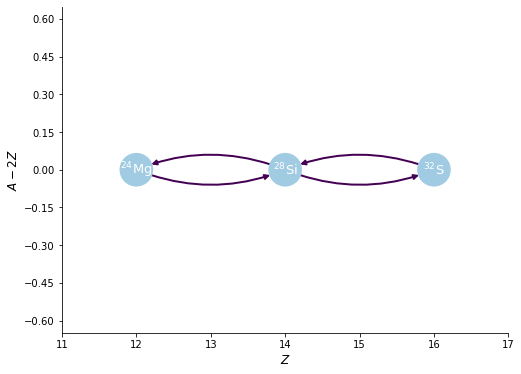

In [18]:
newlib = reaclib.linking_nuclei(["he4", "mg24", "si28", "s32"])
newpynet = pyna.PythonNetwork(libraries=[newlib])
newpynet.plot(rotated=True, curved_edges=True)

In [19]:
newpynet.write_network("simple_net.py")
import simple_net

In [20]:
rho = 1.e7
T = 3e9

X0 = np.zeros(simple_net.nnuc)
X0[simple_net.jhe4] = 0.5
X0[simple_net.jmg24] = 0.5

Y0 = X0 / simple_net.A

In [21]:
simple_net.names == approx_net.names

True

In [22]:
tmax = 1.e-3
simple_sol = solve_ivp(simple_net.rhs, [0, tmax], Y0, method="BDF",
                       dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-10)

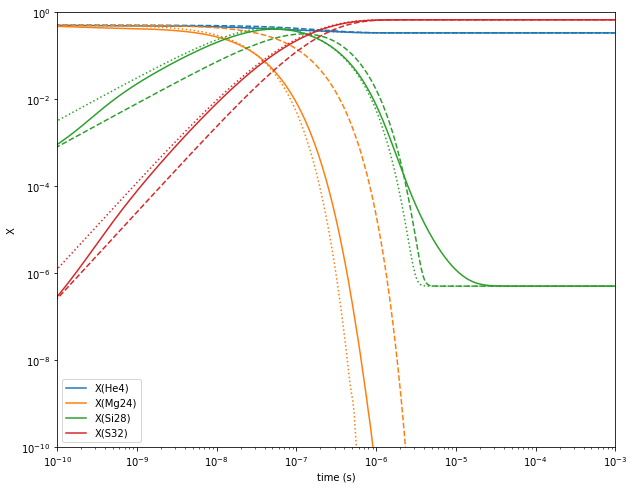

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(approx_net.nnuc):
    ax.loglog(approx_sol.t, approx_sol.y[i,:] * approx_net.A[i],
              linestyle=":", color=f"C{i}")

    idx = full_net.names.index(approx_net.names[i])
    ax.loglog(sol.t, sol.y[idx,:] * full_net.A[idx],
              label=f"X({full_net.names[idx].capitalize()})",              
              linestyle="-", color=f"C{i}")

    idx = simple_net.names.index(approx_net.names[i])
    ax.loglog(simple_sol.t, simple_sol.y[idx,:] * simple_net.A[idx],
              linestyle="--", color=f"C{i}")


ax.legend()
ax.set_xlim(1.e-10, 1.e-3)
ax.set_ylim(1.e-10, 1)

ax.set_xlabel("time (s)")
ax.set_ylabel("X")
fig.set_size_inches((10, 8))
fig.savefig("approximate_comparison.pdf")

Here we see all 3 networks.  The full network (7 nuclei) is the solid lines.  The approximate version of that is the dotted line.  We see that they track reasonably well, especially when the abundance is high.  The dashed line is the version of the network that has the same 4 nuclei as the approximate network, but with out approximating the $(\alpha, p)(p,\gamma)$ links, so we see that the ${}^{24}\mathrm{Mg}$ takes longer to burn.